# Inference comparing different models and simulated data

In [54]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
import theano

In [55]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Full SIR model
Let's start with the SIR model (S(t),I(t)), with LogNormal data. See Data Simulation Notebook for details on how the data was generated. 

In [56]:
data = np.load('logNSIRdata.npy')
data.shape

(80, 2)

In [57]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]

In [4]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0, 20, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)


/usr/local/lib/python3.8/dist-packages/theano/gpuarray/dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(


### Forcing ${\cal R}_0 \geq 1$
In the first inference, with this model we will place a prior on ${\cal R}_0$ with a lower bound of 1, so that it guarantees that every sample of $\beta$ is greater or equal to $\gamma$. In other words, we are inducing the prior of $\beta$ from that of ${\cal R}_0$.

In [6]:
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # Distribuições a priori
    # R0 é limitada inferiormente em 1 para sempre termos uma epidemia.
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    gam = pm.Lognormal('gamma', pm.math.log(2), 2)
    beta = pm.Deterministic('beta', gam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, gam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=data)
#     db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(2000, tune=1000, cores=8, chains=4)

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [gamma, R0, sigma]


/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local

In [ ]:
pdata = az.from_pymc3(trace=trace)

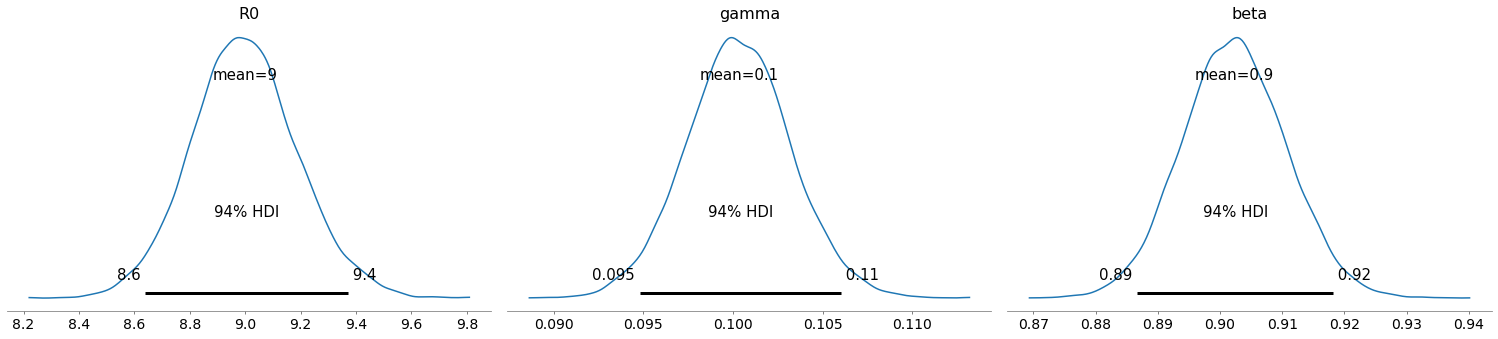

In [21]:
az.plot_posterior(pdata,var_names=['R0','gamma', 'beta']);

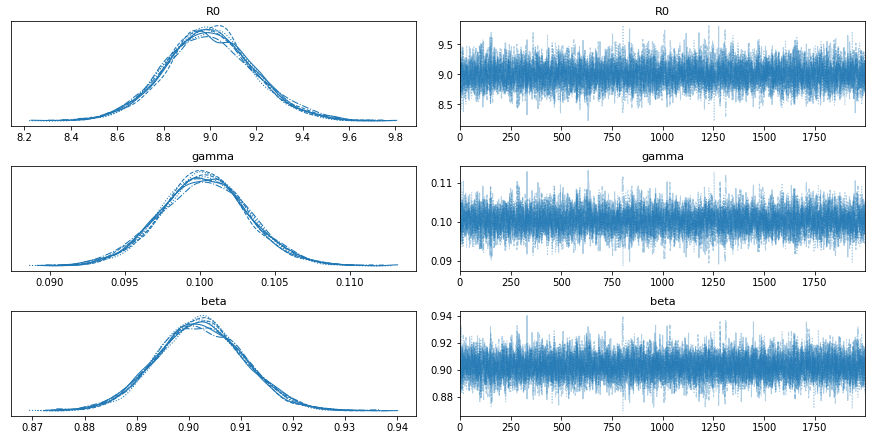

In [17]:
az.plot_trace(data,var_names=['R0','gamma', 'beta']);

### Letting $\beta$ and $\gamma$ vary independently
Contrarily  to what we did above let's remove the constraint of ${\cal R}_ \geq 1$. Now, $\beta \sim LogN(4,2)$

In [58]:
with pm.Model() as model2:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    gam = pm.Lognormal('gamma', pm.math.log(2), 2)
    beta = pm.Lognormal('beta', pm.math.log(4), 2)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, gam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sigma=sigma, observed=data)
#     db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace2 = pm.sample(1000, tune=500, cores=8, chains=4)

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [beta, gamma, sigma]


/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np

In [59]:
pdata2 = az.from_pymc3(trace=trace2)

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


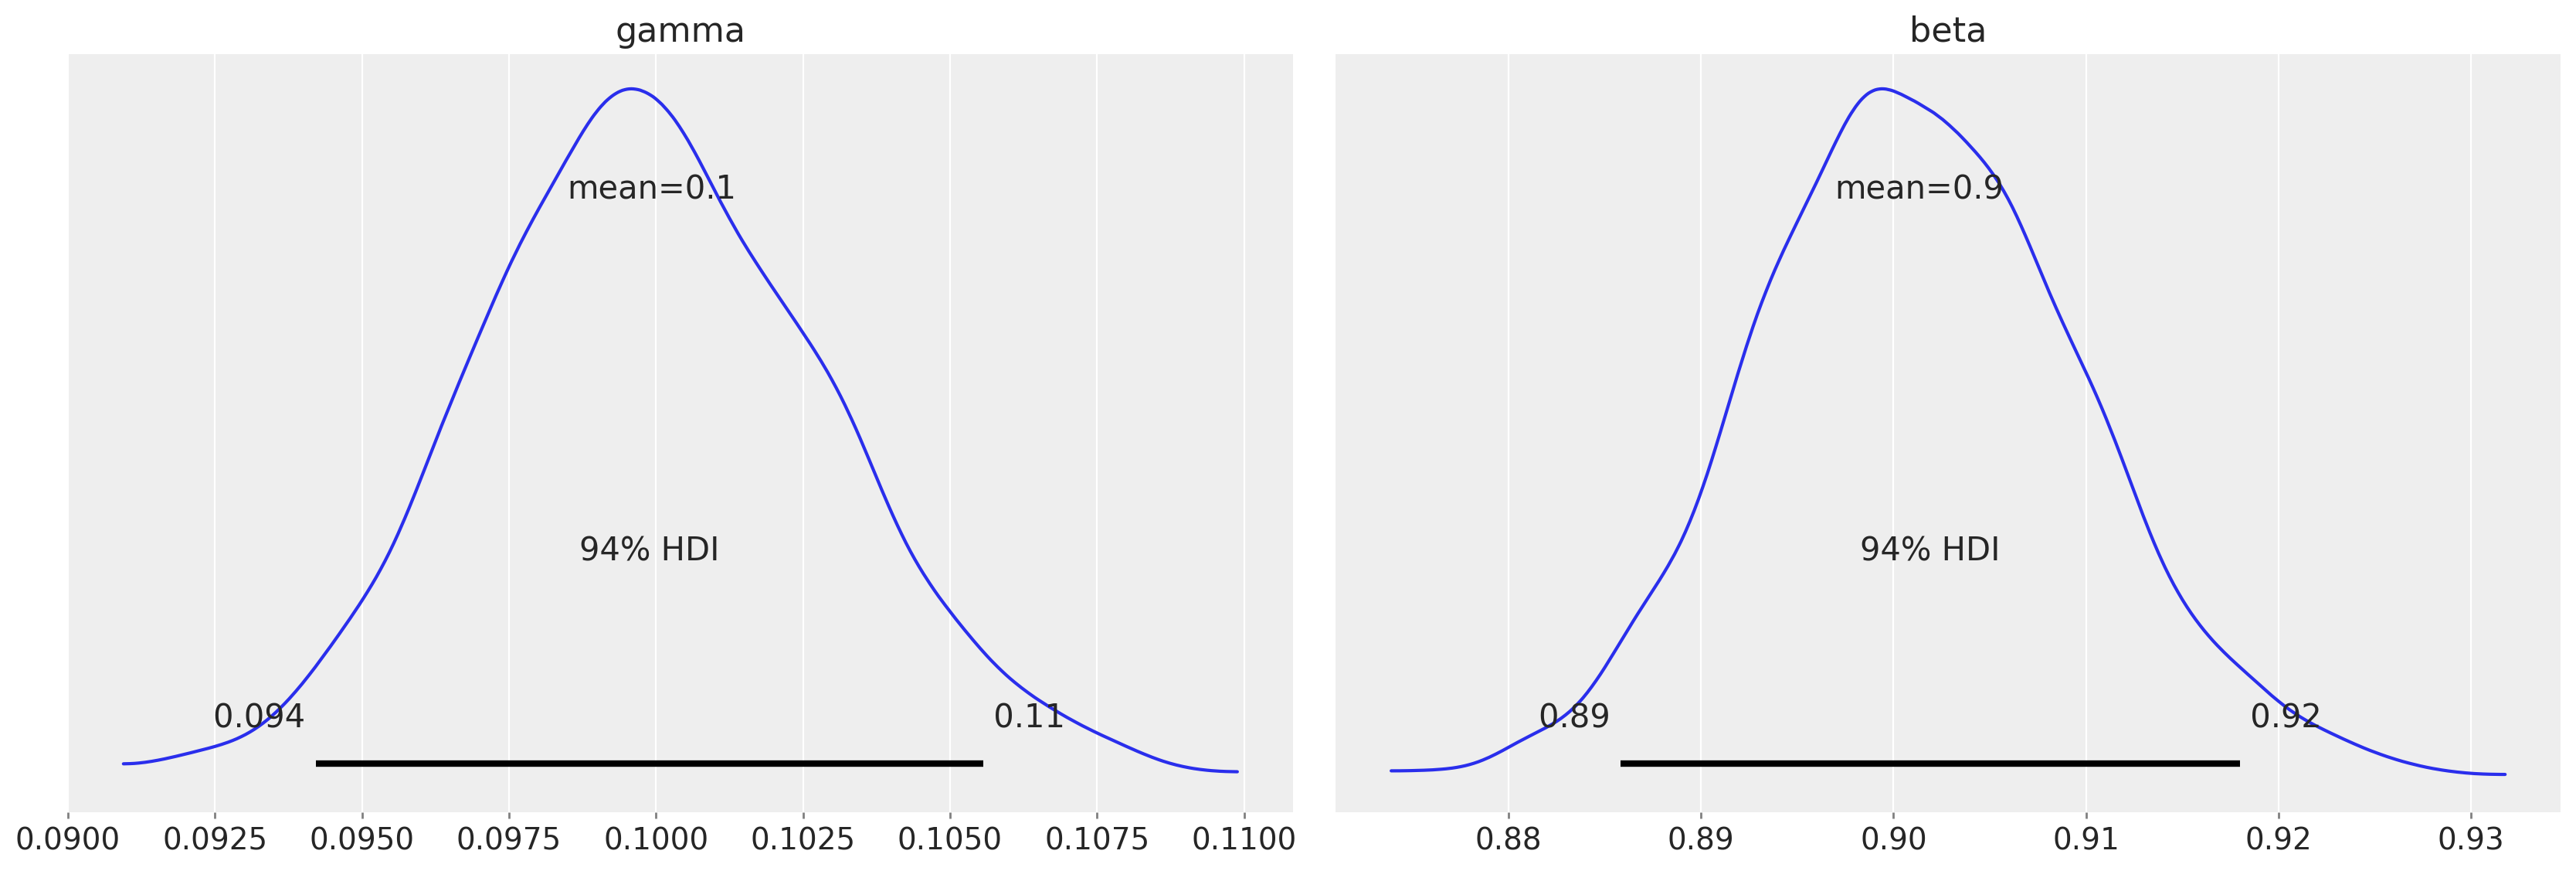

In [60]:
az.plot_posterior(pdata2,var_names=['gamma', 'beta']);

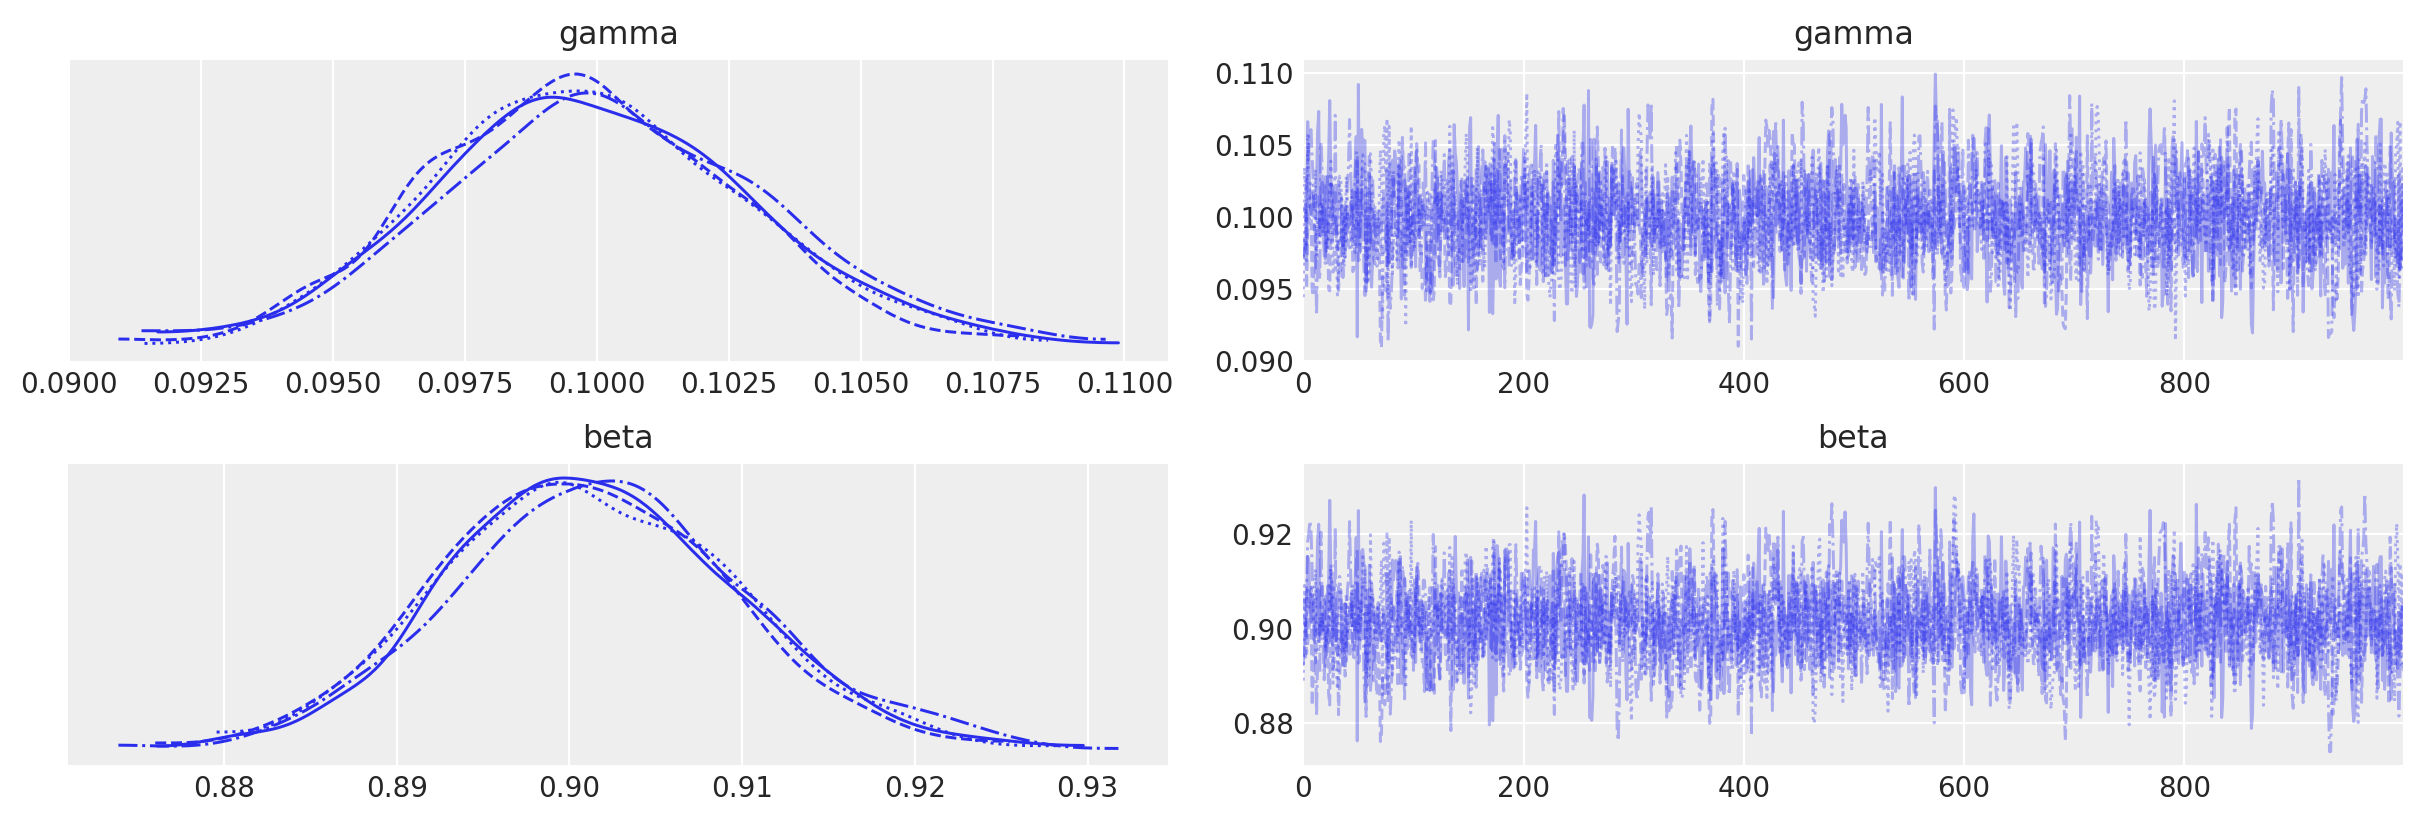

In [61]:
az.plot_trace(pdata2,var_names=['gamma', 'beta']);

## Single equation SIR: R(t) only

In [31]:
def SIR1D(y,t,p):
    N = 100
    R = y[0]
    R0, gamma, S0 = p[0],p[1],p[2]
    return [
        gamma * (N - R - (S0 * np.exp(-R0 * R)))
    ]

In [44]:
rdata = np.load('robs.npy')
rdata.shape =len(rdata),1

In [33]:
sir1d_model = DifferentialEquation(
    func=SIR1D,
    times=np.arange(0, 20, 0.25),
    n_states=1,
    n_theta=3,
    t0=0,
)

In [49]:
with pm.Model() as model1D:
    sigma = pm.HalfCauchy('sigma', 1)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
    gam = pm.Lognormal('gamma', pm.math.log(2), 2)
    S0 = pm.Bound(pm.Lognormal, upper=pm.math.log(100))('S0', pm.math.log(98),2)
    r_curve = sir1d_model(y0=[1], theta=[R0, gam, S0])

    Y = pm.Lognormal('Y', mu=pm.math.log(r_curve), sigma=sigma, observed=rdata)
    trace_r = pm.sample(1000, tune=500, cores=8, chains=4)

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [S0, gamma, R0, sigma]


/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 638 seconds.
There were 510 divergences after tuning. Increase `target_accept` or reparameterize.
There were 597 diver

In [50]:
data_R = az.from_pymc3(trace=trace_r)

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


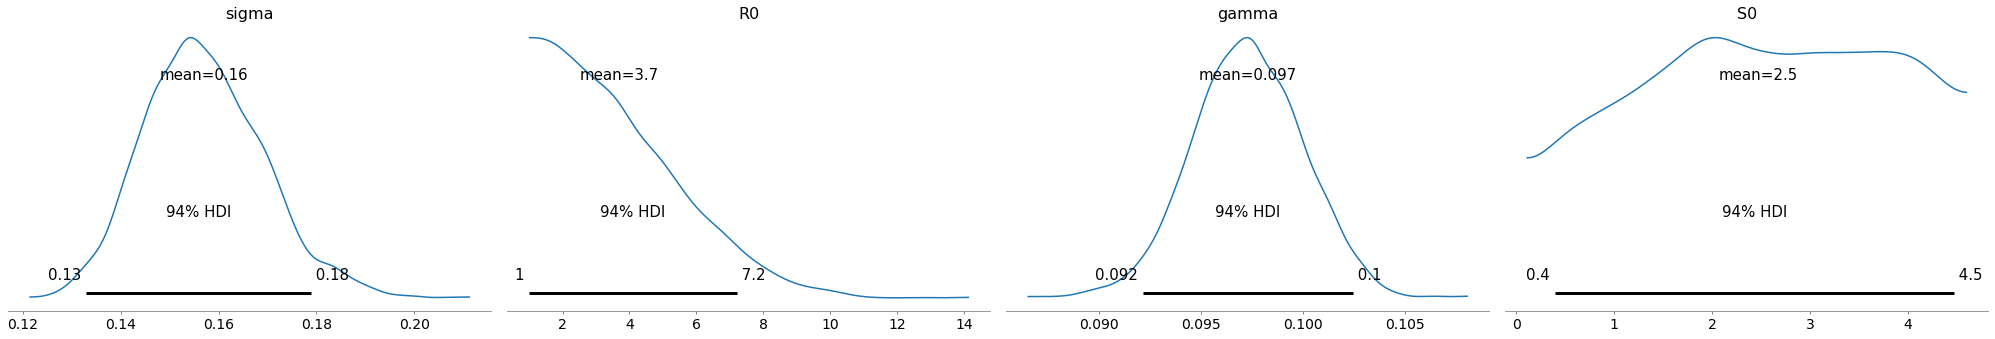

In [51]:
az.plot_posterior(data_R);

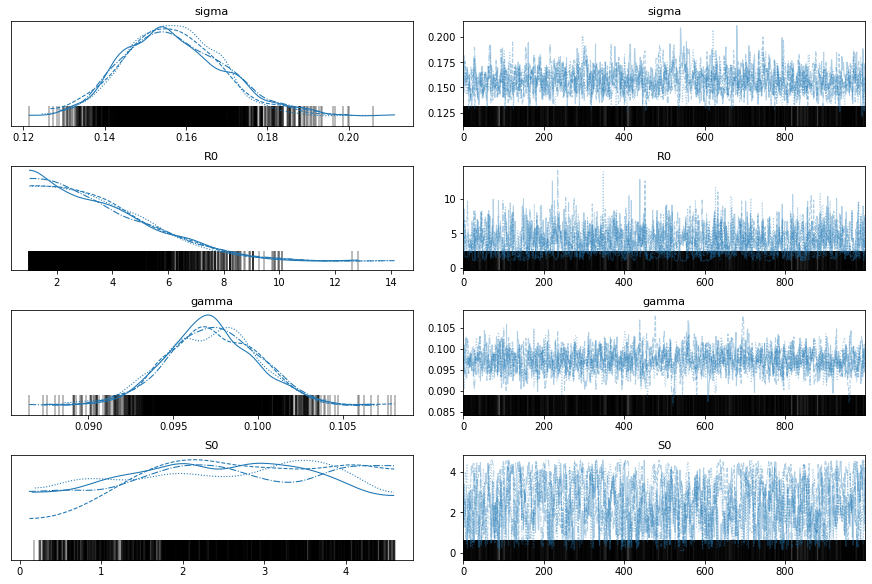

In [52]:
az.plot_trace(data_R);

### Inducing R0 prior from $\beta$ and $\gamma$'s priors

In [62]:
with pm.Model() as model1D2:
    sigma = pm.HalfCauchy('sigma', 1)
    
    gam = pm.Lognormal('gamma', pm.math.log(2), 2)
    beta = pm.Lognormal('beta', pm.math.log(4), 2)
    R0 = pm.Deterministic('R0',beta/gam)
    S0 = pm.Bound(pm.Lognormal, upper=pm.math.log(100))('S0', pm.math.log(98),2)
    r_curve = sir1d_model(y0=[1], theta=[R0, gam, S0])

    Y = pm.Lognormal('Y', mu=pm.math.log(r_curve), sigma=sigma, observed=rdata)
    trace_r2 = pm.sample(1000, tune=500, cores=8, chains=4)

/usr/local/lib/python3.8/dist-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [S0, beta, gamma, sigma]


/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/usr/local/lib/python3.8/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 369 seconds.
There were 626 divergences after tuning. Increase `target_accept` or reparameterize.
There were 743 diver

In [63]:
data_R2 = az.from_pymc3(trace=trace_r2)

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


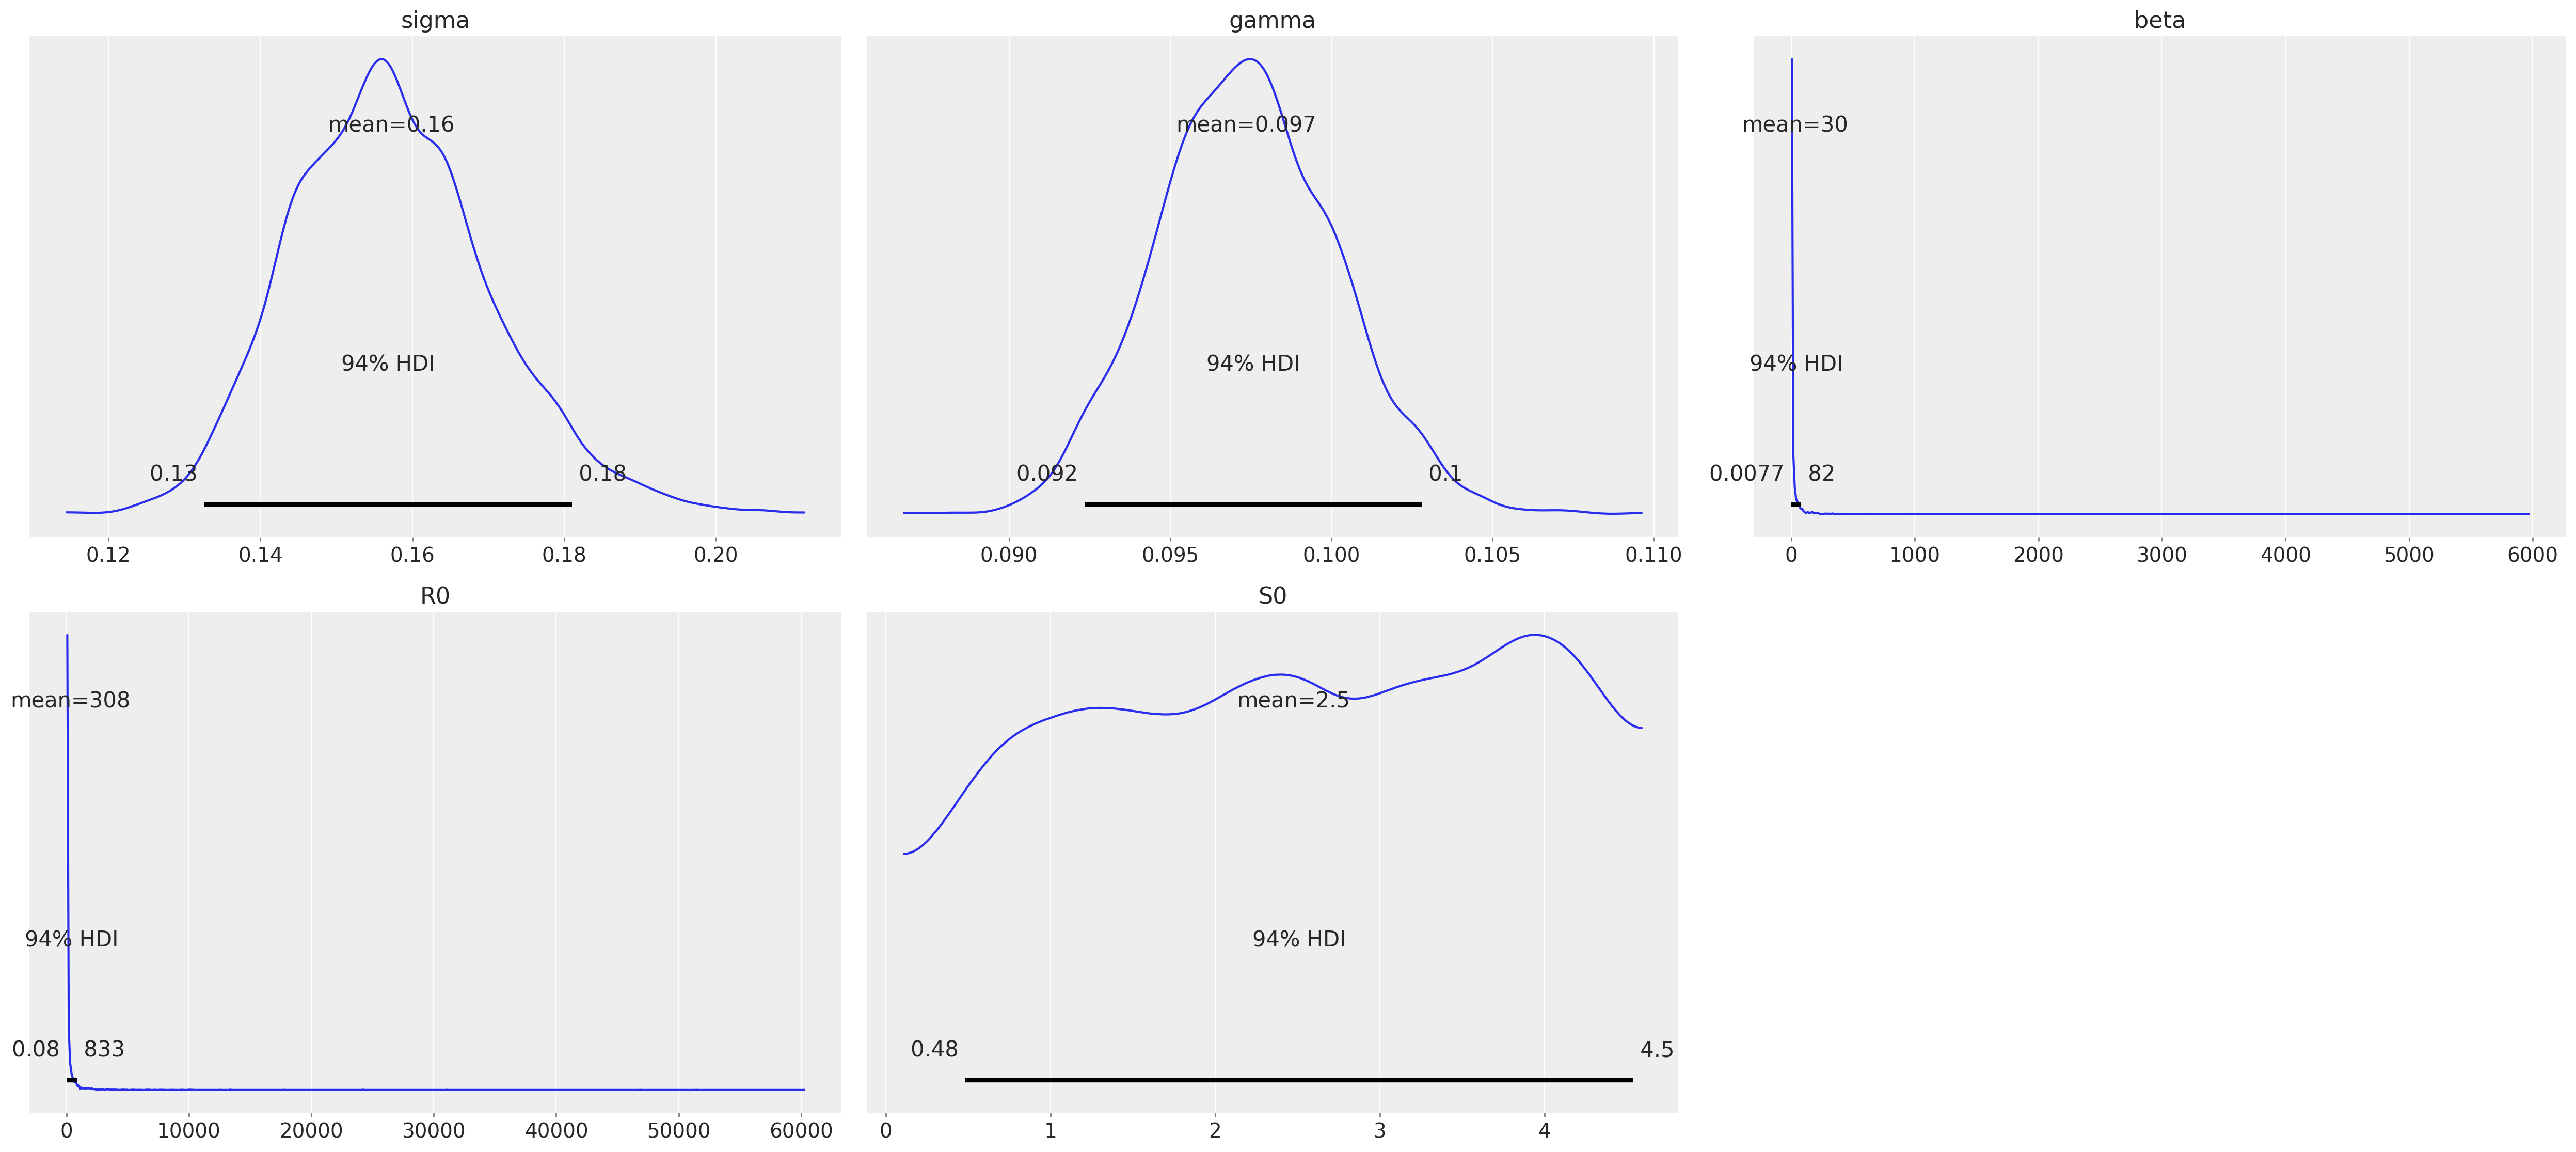

In [64]:
az.plot_posterior(data_R2);

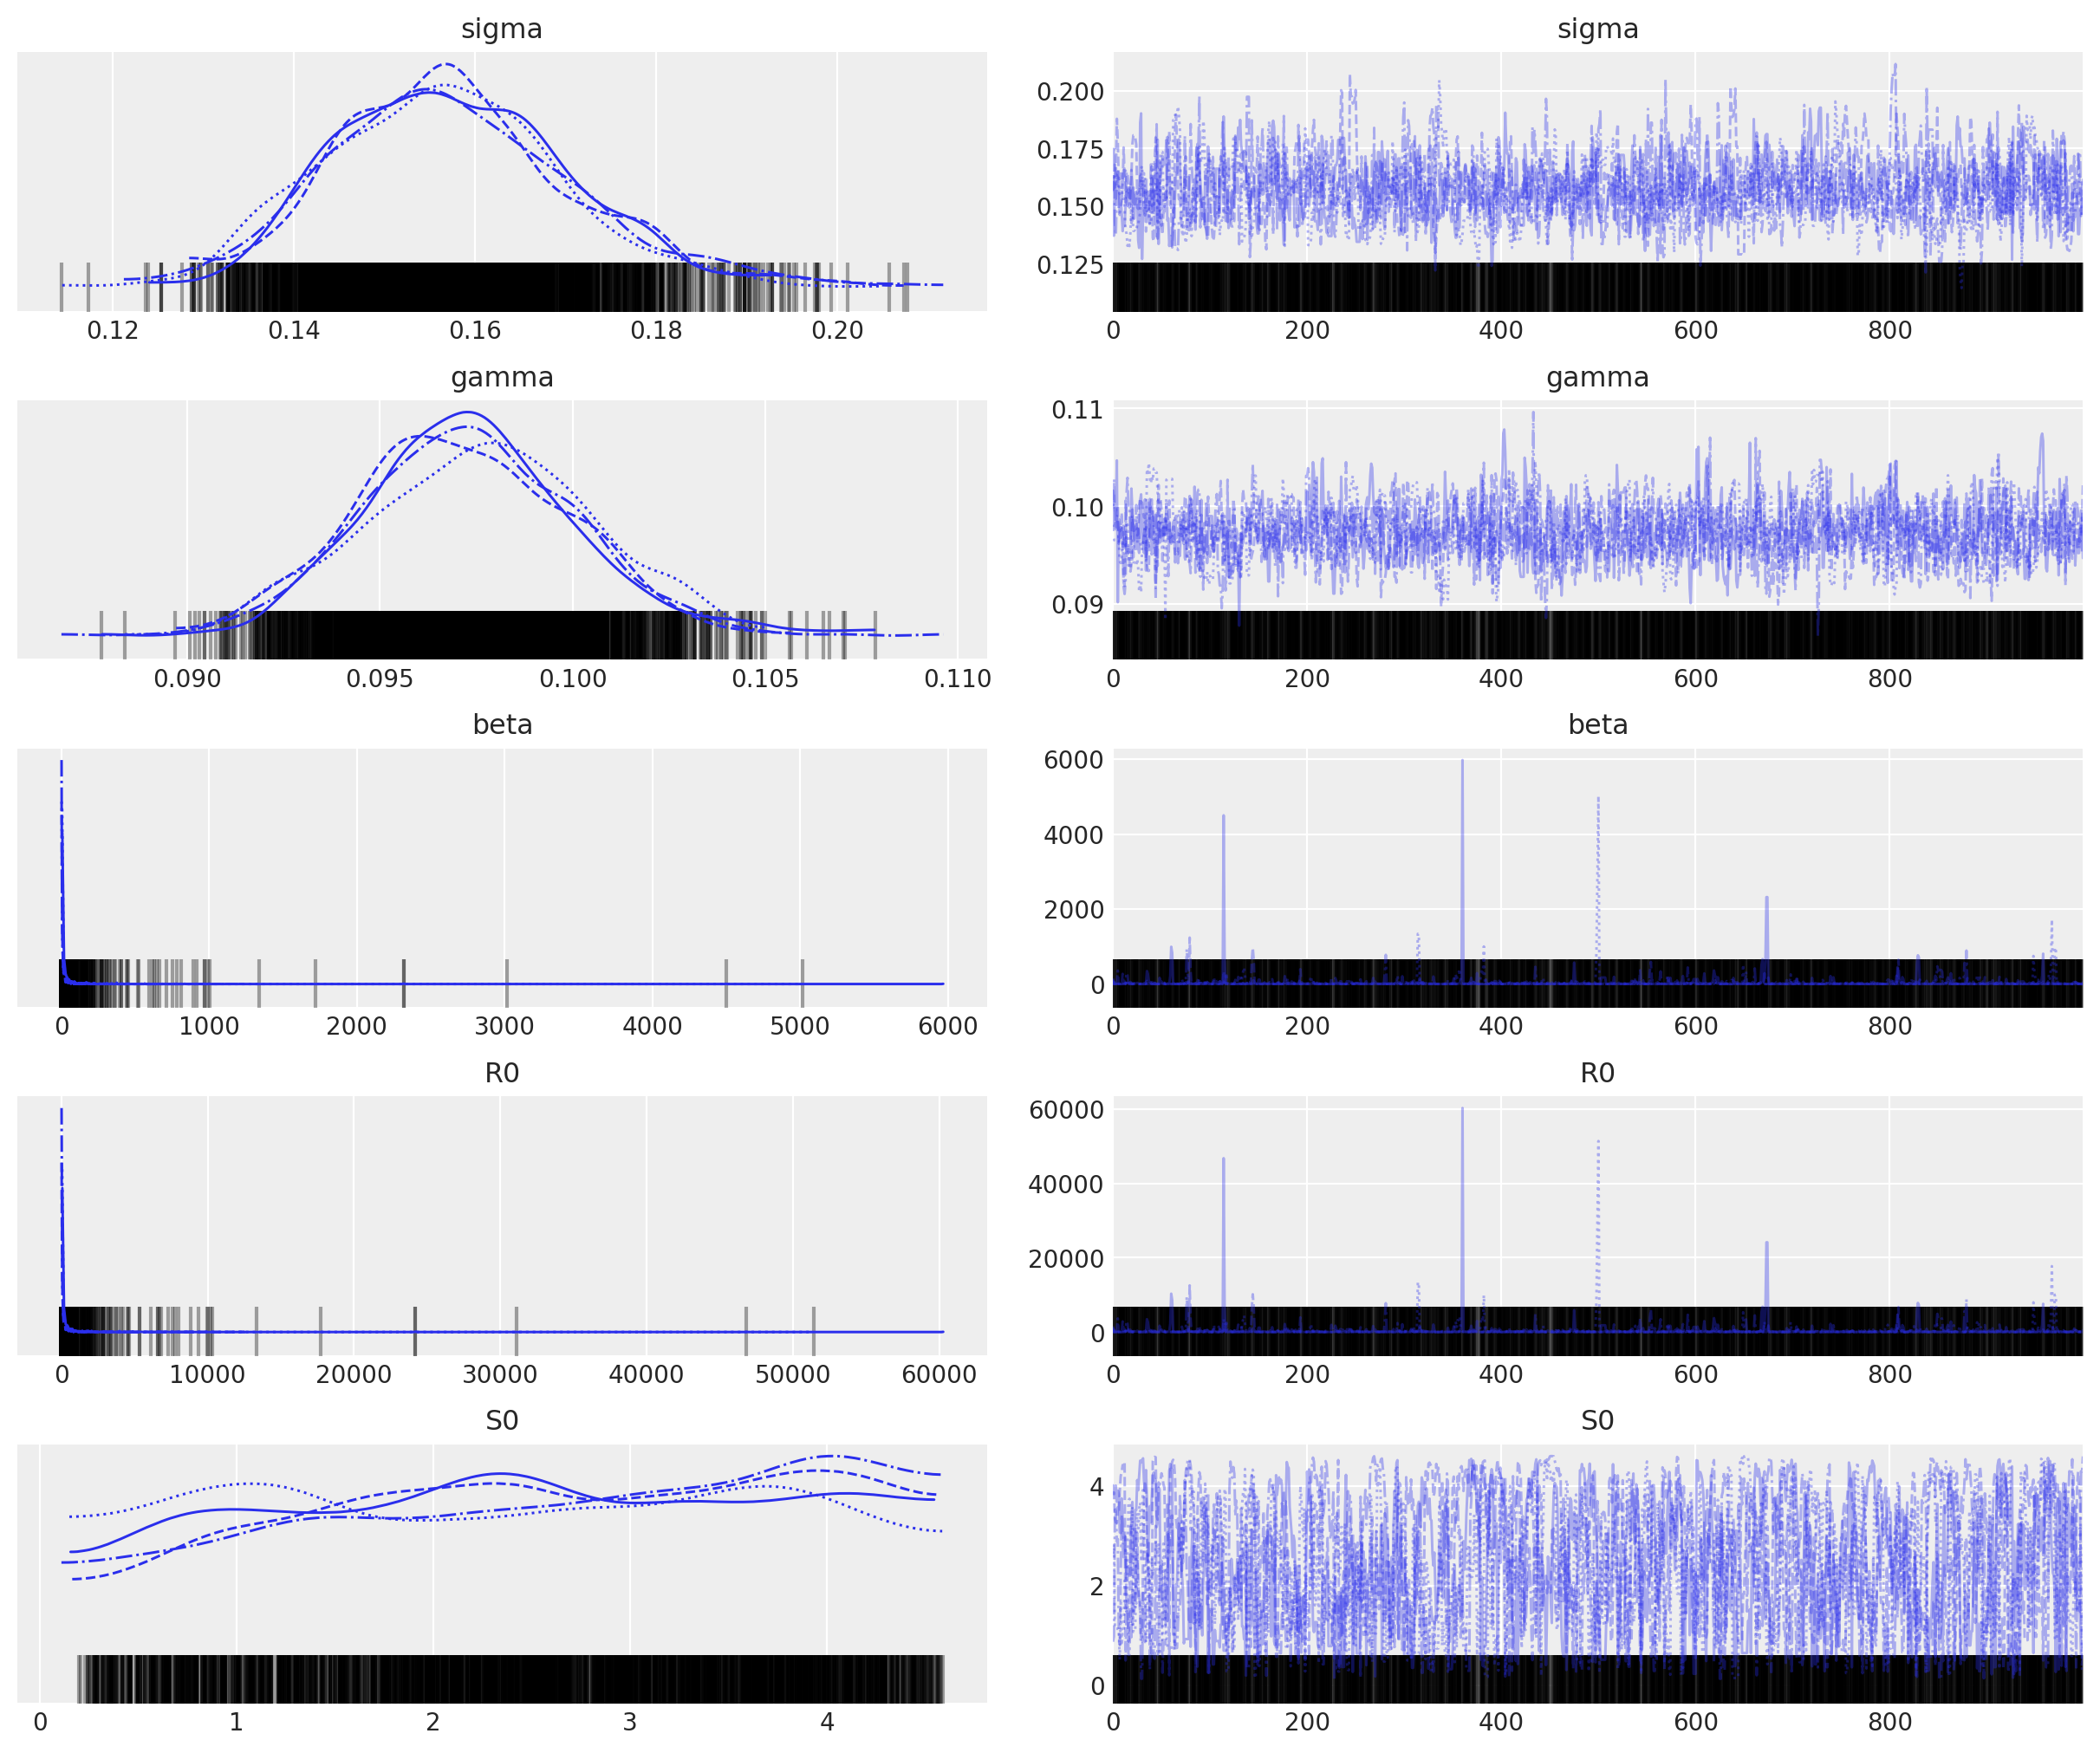

In [65]:
az.plot_trace(data_R2);